In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

from tensorflow import keras
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# 1. Load MNIST data
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# 2. Normalize data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# 3. Reshape for CNN input
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)


# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)
datagen.fit(X_train)

# 4. Build a simple CNN (Convolution Neural Network) model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 5. Train the model
history = model.fit(X_train, y_train, epochs=15, validation_split=0.1)

# 6. Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.3f}")




c:\Users\Ampua\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9100 - loss: 0.2886 - val_accuracy: 0.9857 - val_loss: 0.0515
Epoch 2/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 38s 23ms/step - accuracy: 0.9727 - loss: 0.0930 - val_accuracy: 0.9883 - val_loss: 0.0437
Epoch 3/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - accuracy: 0.9805 - loss: 0.0648 - val_accuracy: 0.9910 - val_loss: 0.0331
Epoch 4/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.9836 - loss: 0.0547 - val_accuracy: 0.9920 - val_loss: 0.0287
Epoch 5/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 36s 22ms/step - accuracy: 0.9864 - loss: 0.0467 - val_accuracy: 0.9923 - val_loss: 0.0283
Epoch 6/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 34s 20ms/step - accuracy: 0.9877 - loss: 0.0410 - val_accuracy: 0.9928 - val_loss: 0.0257
Epoch 7/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.9890 - loss: 0.0357 - val_accuracy: 0.9938 - val_loss: 0.0250
Epoch 8/15
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.9903 -

In [ ]:
# MNIST-style preprocessing for hand-drawn images
def preprocess_handdrawn(img_path):
    img = Image.open(img_path).convert('L')
    img_np = np.array(img)
    
    # Binarize: everything < 200 is foreground
    bin_img = (img_np < 200).astype(np.uint8)
    coords = np.argwhere(bin_img)
    if coords.size == 0:
        raise ValueError('No digit found in image.')
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0) + 1
    cropped = img_np[y0:y1, x0:x1]

    # Resize to 20x20
    digit = Image.fromarray(cropped).resize((20, 20), Image.LANCZOS)

    # Paste into center of 28x28
    new_img = Image.new('L', (28, 28), 255)
    upper_left = ((28 - 20) // 2, (28 - 20) // 2)
    new_img.paste(digit, upper_left)
    img_arr = np.array(new_img, dtype=np.float32) / 255.0
    img_arr = img_arr.reshape(1, 28, 28, 1)
    return img_arr

# Explanation
print('\nThis function preprocesses hand-drawn digit images to make them suitable for the CNN model.')
print('It converts the image to grayscale, crops it to the bounding box of the digit, resizes it to 20x20 pixels, and centers it in a 28x28 image.')



This function preprocesses hand-drawn digit images to make them suitable for the CNN model.
It converts the image to grayscale, crops it to the bounding box of the digit, resizes it to 20x20 pixels, and centers it in a 28x28 image.


In [19]:
# Retrain the model with augmentation and callbacks
EarlyStopping = keras.callbacks.EarlyStopping
ModelCheckpoint = keras.callbacks.ModelCheckpoint

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('best_number_mnist_cnn.h5', save_best_only=True)
] # stops training early if validation accuracy does not improve

history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=20, validation_data=(X_test, y_test),
                    callbacks=callbacks)  #more epochs

# Explanation
print('This function sets up callbacks for early stopping and model checkpointing during training.')

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9754 - loss: 0.0855

938/938 ━━━━━━━━━━━━━━━━━━━━ 46s 48ms/step - accuracy: 0.9762 - loss: 0.0831 - val_accuracy: 0.9946 - val_loss: 0.0141
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9761 - loss: 0.0796

938/938 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.9760 - loss: 0.0818 - val_accuracy: 0.9949 - val_loss: 0.0138
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 46s 49ms/step - accuracy: 0.9775 - loss: 0.0770 - val_accuracy: 0.9940 - val_loss: 0.0157
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.9783 - loss: 0.0763 - val_accuracy: 0.9953 - val_loss: 0.0146
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.9786 - loss: 0.0749 - val_accuracy: 0.9956 - val_loss: 0.0141
This function sets up callbacks for early stopping and model checkpointing during training.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


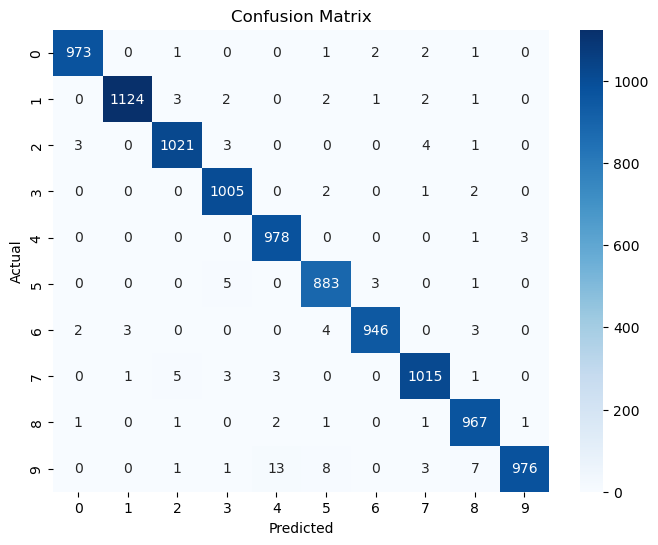

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.98      1.00      0.99       982
           5       0.98      0.99      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       1.00      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
# 7. Confusion matrix and Save the model

# Predict labels for test set
y_pred = np.argmax(model.predict(X_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


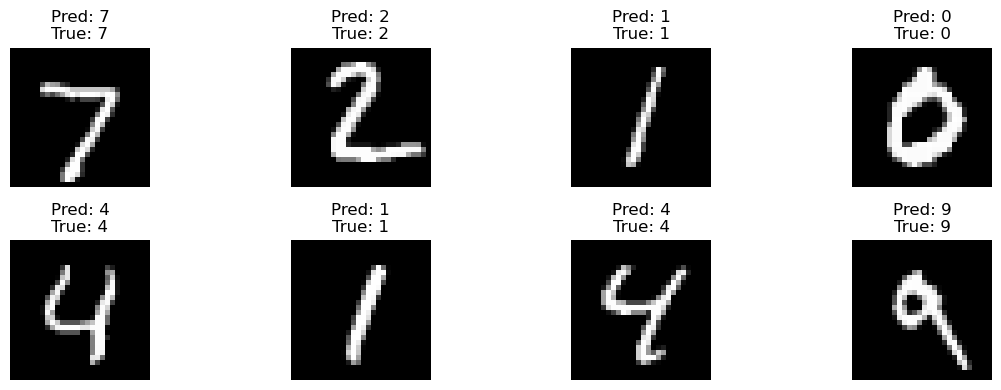

In [5]:
# Example predictions with images
num_examples = 8
plt.figure(figsize=(12, 4))
for i in range(num_examples):
    ax = plt.subplot(2, 4, i + 1)
    img = X_test[i].reshape(28, 28)
    pred = np.argmax(model.predict(X_test[i].reshape(1, 28, 28, 1)), axis=1)[0]
    true = y_test[i]
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {pred}\nTrue: {true}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
# Example: Invert a hand-drawn image before prediction if needed
from PIL import Image, ImageOps

img = Image.open('hand3.png').convert('L').resize((28, 28))
img = ImageOps.invert(img)  # Invert if background is white and digit is black
img_arr = np.array(img, dtype=np.float32) / 255.0
img_arr = img_arr.reshape(1, 28, 28, 1)
pred = np.argmax(model.predict(img_arr), axis=1)[0]
print(f'Predicted digit: {pred}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
Predicted digit: 3


In [11]:
# Save the model
model.save('number_mnist_cnn.h5')
print("\nModel saved as number_mnist_cnn.h5")


Model saved as number_mnist_cnn.h5


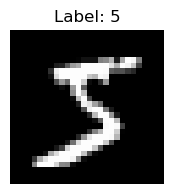

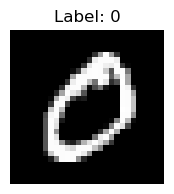

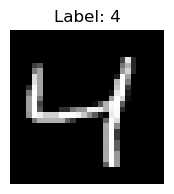

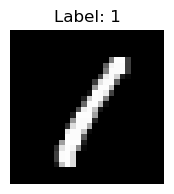

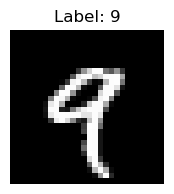

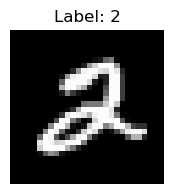

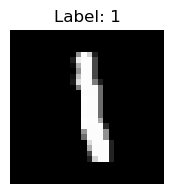

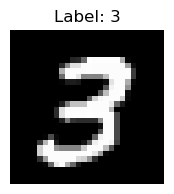

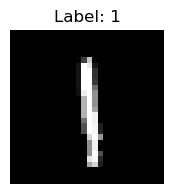

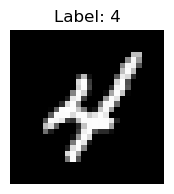

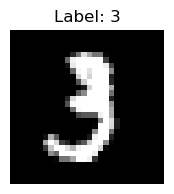

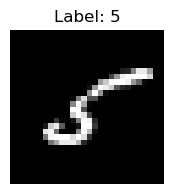

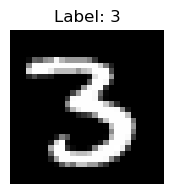

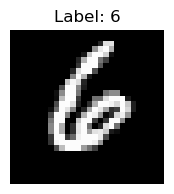

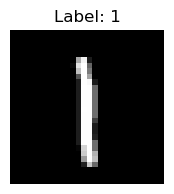

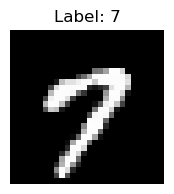

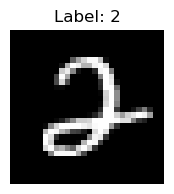

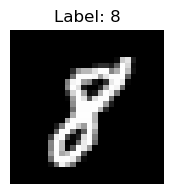

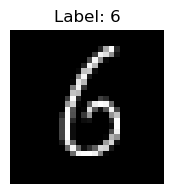

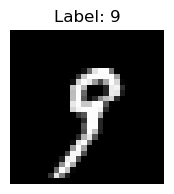

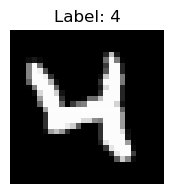

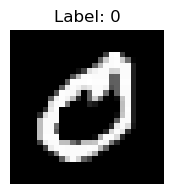

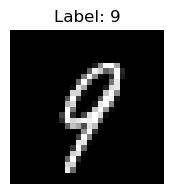

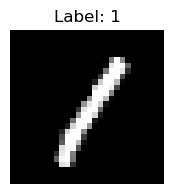

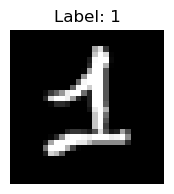

In [9]:
# Show the first 25 images with their labels, one per cell
for i in range(25):
    plt.figure(figsize=(2,2))
    plt.imshow(X_train[i].reshape(28,28), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
    plt.show()